Imports

In [1]:
import os.path
import pandas as pd
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use('ggplot')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Read Data

In [2]:
parent_dir = os.path.dirname(os.path.abspath("__file__"))
f = parent_dir + r'/../data/intermittent-renewables-production-france.csv'

class CONFIG:
    NAMES_DTYPES = {
        "Source" : str,
        "Production" : np.float32
    }

df = pd.read_csv(
    f,
    parse_dates=["Date and Hour", "Date"],
    infer_datetime_format=True,
    dtype=CONFIG.NAMES_DTYPES
    )

In [3]:
df.dropna(inplace=True)

In [4]:
df.head()

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-07-22 20:00:00+02:00,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July
1,2020-07-23 07:00:00+02:00,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July
2,2020-07-23 16:00:00+02:00,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July
3,2020-07-23 19:00:00+02:00,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July
4,2020-07-23 23:00:00+02:00,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59804 entries, 0 to 59805
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date and Hour  59804 non-null  object        
 1   Date           59804 non-null  datetime64[ns]
 2   StartHour      59804 non-null  object        
 3   EndHour        59804 non-null  object        
 4   Source         59804 non-null  object        
 5   Production     59804 non-null  float32       
 6   dayOfYear      59804 non-null  int64         
 7   dayName        59804 non-null  object        
 8   monthName      59804 non-null  object        
dtypes: datetime64[ns](1), float32(1), int64(1), object(6)
memory usage: 4.3+ MB


Pre Process Data

In [6]:
df['StartHour'] = df['StartHour'].replace('24:00:00', '00:00:00')
df['EndHour'] = df['EndHour'].replace('24:00:00', '00:00:00')

df['StartHour'] = pd.to_datetime(df['StartHour'])
df['EndHour'] = pd.to_datetime(df['EndHour'])

df['TimeDifference'] = df['EndHour'] - df['StartHour']

df['Total_time'] = df['TimeDifference'].dt.components['hours']

df['Total_time']=df['Total_time']*60

df = df.drop(['TimeDifference', 'StartHour', 'EndHour', 'Date and Hour', 'Date'], axis=1)

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
lst = ['Source','dayName','monthName']
for i in lst:
    df[i] = le.fit_transform(df[i])

In [8]:
df.head()

,Source,Production,dayOfYear,dayName,monthName,Total_time
0,0,244.0,204,6,5,60
1,0,223.0,205,4,5,60
2,0,2517.0,205,4,5,60
3,0,658.0,205,4,5,60
4,0,0.0,205,4,5,60


<AxesSubplot:>

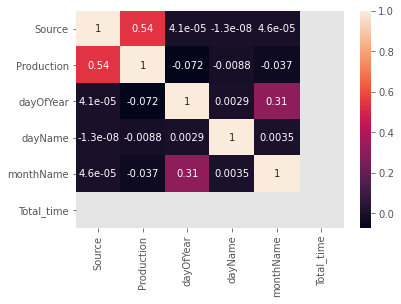

In [9]:
sns.heatmap(df.corr(),annot=True)

Split Data

In [12]:
# splitting the dataset
X=df.drop(['Production'],axis=1)
y=df['Production']

In [16]:
X.head()

,Source,dayOfYear,dayName,monthName,Total_time
0,0,204,6,5,60
1,0,205,4,5,60
2,0,205,4,5,60
3,0,205,4,5,60
4,0,205,4,5,60


In [13]:
# scaling using standard scaler
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
X_ss=ss.fit_transform(X)

In [15]:
X_ss

array([[-1.00003344,  0.30058321,  1.4978966 , -0.10449448,  0.        ],
       [-1.00003344,  0.31011271,  0.49903163, -0.10449448,  0.        ],
       [-1.00003344,  0.31011271,  0.49903163, -0.10449448,  0.        ],
       ...,
       [-1.00003344,  0.0814047 , -1.49869831,  0.19008401,  0.        ],
       [-1.00003344,  0.0814047 , -1.49869831,  0.19008401,  0.        ],
       [-1.00003344,  0.0814047 , -1.49869831,  0.19008401,  0.        ]])

In [17]:
# Performing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_ss,y,test_size=0.2,random_state=0)

Model Data

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [19]:
# linear regression
mr=LinearRegression()
mr.fit(X_train,y_train)
y_pred=mr.predict(X_test)

In [20]:
print("mean absolute error:",mean_absolute_error(y_test,y_pred))
print("mean squared error:",mean_squared_error(y_test,y_pred))
print("root mean squared error:",np.sqrt(mean_squared_error(y_test,y_pred)))
print("r2-score:",r2_score(y_test,y_pred))

mean absolute error: 1986.878780294415
mean squared error: 6988177.527176466
root mean squared error: 2643.5161295472485
r2-score: 0.3051884617025953


In [21]:
rs=RandomForestRegressor()
rs.fit(X_train,y_train)
y_pred1=rs.predict(X_test)
y_pred1

array([7010.91826089,  136.36358185, 1867.64709204, ..., 2304.52963551,
        596.97690618, 3760.11895365])

In [22]:
print("mean absolute error:",mean_absolute_error(y_test,y_pred1))
print("mean squared error:",mean_squared_error(y_test,y_pred1))
print("root mean squared error:",np.sqrt(mean_squared_error(y_test,y_pred1)))
print("R2 score:",r2_score(y_test,y_pred1)) 

mean absolute error: 1165.3635683096647
mean squared error: 2297547.264065374
root mean squared error: 1515.7662300187897
R2 score: 0.7715624220123014


Save Model

In [23]:
import pickle

In [24]:
# save the model to disk
parent_dir = os.path.dirname(os.path.abspath("__file__"))
p = parent_dir + r'/../model/model.bin'
pickle.dump(rs, open(p, 'wb'))

In [25]:
train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

In [26]:
print(df.shape)
print(train.shape)
print(test.shape)
print(validate.shape)

(59804, 6)
(35882, 6)
(11961, 6)
(11961, 6)


In [27]:
X_val=validate.drop(['Production'],axis=1)
y_val=validate['Production']

In [28]:
X_val.head()

,Source,dayOfYear,dayName,monthName,Total_time
16803,0,313,3,9,60
24419,1,178,3,6,60
1573,1,45,0,3,60
45304,1,260,2,11,60
2423,0,49,5,3,60


In [29]:
X_ss=ss.fit_transform(X_val)

In [31]:
# load the model from disk
loaded_model = pickle.load(open(p, 'rb'))
result = loaded_model.score(X_ss, y_val)
print(result)

0.8049293822034228
